#Trabalho Final

#### Dataset:
Sinistros de Trânsito Agrupados Por Ocorrência em 2007 (https://dados.gov.br/dados/conjuntos-dados/sinistros-de-transito-agrupados-por-ocorrencia), complementado pela estimativa da população de cada município em 2006 (https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?edicao=17283&t=downloads)

In [1]:
!pip install unidecode xlrd
import pandas as pd
import numpy as np
import re
import unidecode
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
con = duckdb.connect()
import scipy.stats as st
import statsmodels.formula.api as smf

In [28]:
df = pd.read_csv("datatran2007.csv",sep=";")
df_mun = pd.read_excel("POP2006-TCU.xls", header=[3, 4])[:-3]
df_mun.columns = ["SIGLA U.F.","COD U.F.", "COD MUNIC","MUNICÍPIOS","POP-2006"]
df_mun = df_mun[['SIGLA U.F.', 'MUNICÍPIOS', 'POP-2006']].copy()
df_mun.columns = ['uf', 'municipio', 'pop_2006']

/tmp/ipykernel_11574/2596296201.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("datatran2007.csv",sep=";")


In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127675 entries, 0 to 127674
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      127675 non-null  int64 
 1   data_inversa            127675 non-null  object
 2   dia_semana              127675 non-null  object
 3   horario                 127675 non-null  object
 4   uf                      127675 non-null  object
 5   br                      127675 non-null  object
 6   km                      127675 non-null  object
 7   municipio               127675 non-null  object
 8   causa_acidente          127675 non-null  object
 9   tipo_acidente           127675 non-null  object
 10  classificacao_acidente  127675 non-null  object
 11  fase_dia                127675 non-null  object
 12  sentido_via             127675 non-null  object
 13  condicao_metereologica  127675 non-null  object
 14  tipo_pista              127675 non-n

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,uso_solo,ano,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos
0,10,11/06/2007,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de aten��o,Colis�o frontal,...,Rural,2007,9,0,4,0,5,0,4,6
1,10,11/06/2007,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de aten��o,Colis�o frontal,...,Rural,2007,9,0,4,0,5,0,4,6
2,1032898,13/08/2007,Segunda,14:25:00,MG,40,585.5,ITABIRITO,Outras,Sa�da de Pista,...,Rural,2007,3,0,0,1,2,0,1,1
3,1051130,12/02/2007,Segunda,02:10:00,MA,135,11.0,SAO LUIS,Animais na Pista,Atropelamento de animal,...,Urbano,2007,5,2,2,1,0,0,3,1
4,1066824,20/11/2007,Ter�a,05:30:00,CE,222,30.8,CAUCAIA,Defeito mec�nico em ve�culo,Capotamento,...,Rural,2007,1,0,1,0,0,0,1,1


In [4]:
df_mun.info()
df_mun.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uf         5564 non-null   object 
 1   municipio  5564 non-null   object 
 2   pop_2006   5564 non-null   float64
dtypes: float64(1), object(2)
memory usage: 130.5+ KB


,uf,municipio,pop_2006
5559,GO,Vianópolis,12950.0
5560,GO,Vicentinópolis,6591.0
5561,GO,Vila Boa,3617.0
5562,GO,Vila Propício,5001.0
5563,DF,Brasília,2383784.0


##2 Integração e Limpeza de Dados

In [5]:
df_raw = df.copy()
con.register("acidentes_raw", df_raw)

###2.2 Limpeza de Dados (Obrigatório)

In [6]:
colunas_nao_numericas = [
"dia_semana",
"uf",
"br",
"causa_acidente",
"tipo_acidente",
"classificacao_acidente",
"fase_dia",
"sentido_via",
"condicao_metereologica",
"tipo_pista",
"tracado_via",
"uso_solo",
]

print("Valores unicos para as colunas não numéricas")
for coluna in colunas_nao_numericas:
    print(f"{coluna + " ("+ str(df[coluna].unique().size) +")":30}: {df[coluna].unique()}")

Valores unicos para as colunas não numéricas
dia_semana (7)                : ['Segunda' 'Ter�a' 'Domingo' 'Quinta' 'Quarta' 'Sexta' 'S�bado']
uf (28)                       : ['MG' 'MA' 'CE' 'PR' 'ES' 'GO' 'RJ' 'RS' 'SP' 'RN' 'SC' 'PA' 'PE' 'MT'
 'BA' 'AL' 'TO' 'PI' 'MS' 'SE' 'RO' 'PB' 'AP' 'DF' 'AC' 'RR' 'AM' '(null)']
br (196)                      : [381 40 135 222 230 277 101 251 70 116 158 280 470 60 386 376 316 10 232
 262 282 473 242 290 153 50 343 104 267 163 365 304 364 392 20 287 235 367
 472 402 293 226 324 210 354 414 476 495 424 373 471 110 393 319 601 463
 452 406 407 285 493 174 605 317 428 408 459 468 418 146 465 469 450 423
 401 488 356 405 410 259 361 480 427 460 156 330 425 377 432 80 308 419
 412 429 485 '101' '40' '232' '135' '116' '280' '381' '316' '262' '50'
 '364' '290' '277' '304' '163' '226' '70' '282' '153' '470' '285' '406'
 '354' '324' '20' '476' '365' '488' '10' '222' '158' '60' '230' '393'
 '392' '343' '386' '452' '287' '405' '235' '367' '376' '110' '408' '

In [7]:
regex_data = r'^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[0-2])/[0-9]{4}$'
regex_horario = r'^(?:[01]\d|2[0-3]):[0-5]\d:[0-5]\d$'


def verifica_formato(df,coluna,regex):
    return df[coluna].apply(lambda x: not bool(re.match(regex, x)))

print("Quantidade de entradas com data fora do padrão: " + str(verifica_formato(df,"data_inversa",regex_data).sum()))
print("Quantidade de entradas com horário fora do padrão: " + str(verifica_formato(df,"horario",regex_horario).sum()))

print("km tem dados (null)? " + str("(null)" in df["km"].unique()))
print("municipio tem dados (null)? " + str("(null)" in df["municipio"].unique()))

Quantidade de entradas com data fora do padrão: 0
Quantidade de entradas com horário fora do padrão: 0
km tem dados (null)? True
municipio tem dados (null)? False


In [8]:
colunas_numericas = ['ano', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos']

print("Quantidade de entradas com valor < 0 para as colunas numéricas")
for coluna in colunas_numericas:
    print(f"{coluna}: {df[coluna].apply(lambda x: x < 0).sum()}")

Quantidade de entradas com valor < 0 para as colunas numéricas
ano: 0
pessoas: 0
mortos: 0
feridos_leves: 0
feridos_graves: 0
ilesos: 0
ignorados: 0
feridos: 0
veiculos: 0


###Descrição dos problemas:

Dataset de sinistros:

1. uf tem valor "(null)"
2. br tem valor "(null)"
3. br tem valores inteiros e de texto
4. classificacao_acidente tem valor "(null)"
5. causa_acidente tem valor "Outras"
6. fase_dia tem valor "(null)"
7. condicao_metereologica tem valor "(null)"
8. condicao_metereologica tem valor "Ignorada"
9. km é tipo object
10. km tem valor "(null)"

Dataset de população estimada:

1. municípios possuem assentos e letras minúsculas

Dataset de sinistros:

1. (1) uf tem valor "(null)"
1. (2) br tem valor "(null)"
1. (4) classificacao_acidente tem valor "(null)"
1. (5) causa_acidente tem valor "Outras"
1. (6) fase_dia tem valor "(null)"
1. (7) condicao_metereologica tem valor "(null)"
1. (8) condicao_metereologica tem valor "Ignorada"
1. (10) km tem valor "(null)"

In [9]:
df = df.replace("(null)", np.nan)

df["causa_acidente"] = df["causa_acidente"].replace("Outras", np.nan)
df["condicao_metereologica"] = df["condicao_metereologica"].replace("Ignorada", np.nan)

In [10]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79811 entries, 3 to 127674
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      79811 non-null  int64 
 1   data_inversa            79811 non-null  object
 2   dia_semana              79811 non-null  object
 3   horario                 79811 non-null  object
 4   uf                      79811 non-null  object
 5   br                      79811 non-null  object
 6   km                      79811 non-null  object
 7   municipio               79811 non-null  object
 8   causa_acidente          79811 non-null  object
 9   tipo_acidente           79811 non-null  object
 10  classificacao_acidente  79811 non-null  object
 11  fase_dia                79811 non-null  object
 12  sentido_via             79811 non-null  object
 13  condicao_metereologica  79811 non-null  object
 14  tipo_pista              79811 non-null  object
 15  tracad

Dataset de sinistros:

1. (3) br tem valores inteiros e de texto[

2. (9) km é tipo object

In [11]:
df["km"] = pd.to_numeric(df["km"], errors="coerce")
df["br"] = pd.to_numeric(df["br"], errors="coerce")

Dataset de população estimada:

1. (1) municípios possuem assentos e letras minúsculas

In [12]:
df_mun['municipio'] = (
    df_mun['municipio']
    .str.strip()
    .str.upper()
    .apply(unidecode.unidecode)
    .str.replace("'", "", regex=False)  # remove todas as aspas simples
)

df_mun.head()

,uf,municipio,pop_2006
0,RO,ALTA FLORESTA DOESTE,29005.0
1,RO,ALTO ALEGRE DOS PARECIS,15454.0
2,RO,ALTO PARAISO,16510.0
3,RO,ALVORADA DOESTE,19542.0
4,RO,ARIQUEMES,86924.0


In [13]:
for coluna in ["feridos_leves", "feridos_graves", "ilesos", "ignorados", "feridos", "veiculos"]:
    print(f"{coluna:20}: max: {str(df[coluna].unique().max())} mean: {df[coluna].mean()}")

feridos_leves       : max: 43 mean: 0.4439112403052211
feridos_graves      : max: 34 mean: 0.17204395384094925
ilesos              : max: 46 mean: 1.46408389820952
ignorados           : max: 40 mean: 0.042763528836877125
feridos             : max: 62 mean: 0.6159551941461703
veiculos            : max: 12 mean: 1.7732392777937878


###2.3 Consultas SQL e Visualizações para Diagnóstico de Qualidade

Dados originais:

In [14]:
con.register("acidentes", df)

In [15]:
print("Contagem de valores problemáticos no dataset BRUTO")
con.execute("""
    SELECT
        SUM(CASE WHEN uf = '(null)' OR uf IS NULL THEN 1 ELSE 0 END)               AS n_uf_nulos,
        SUM(CASE WHEN br = '(null)' OR br IS NULL THEN 1 ELSE 0 END)               AS n_br_nulos,
        SUM(CASE WHEN classificacao_acidente = '(null)' THEN 1 ELSE 0 END)         AS n_classificacao_nulos,
        SUM(CASE WHEN causa_acidente = 'Outras' THEN 1 ELSE 0 END)                 AS n_causa_outras,
        SUM(CASE WHEN fase_dia = '(null)' OR fase_dia IS NULL THEN 1 ELSE 0 END)   AS n_fase_dia_nulos,
        SUM(CASE WHEN condicao_metereologica = '(null)' OR condicao_metereologica IS NULL THEN 1 ELSE 0 END) AS n_cond_met_nulos,
        SUM(CASE WHEN condicao_metereologica = 'Ignorada' THEN 1 ELSE 0 END)       AS n_cond_met_ignorada,
        SUM(CASE WHEN km = '(null)' OR km IS NULL THEN 1 ELSE 0 END)               AS n_km_nulos
    FROM acidentes_raw;
""").df()



Contagem de valores problemáticos no dataset BRUTO


,n_uf_nulos,n_br_nulos,n_classificacao_nulos,n_causa_outras,n_fase_dia_nulos,n_cond_met_nulos,n_cond_met_ignorada,n_km_nulos
0,5.0,5.0,5.0,45968.0,25.0,23.0,2967.0,5.0


In [16]:
con.execute("""
    SELECT
        uf,
        br,
        classificacao_acidente,
        causa_acidente,
        fase_dia,
        condicao_metereologica,
        condicao_metereologica,
        km
    FROM acidentes_raw
    WHERE
      uf = '(null)' OR uf IS NULL;
""").df()

,uf,br,classificacao_acidente,causa_acidente,fase_dia,condicao_metereologica,condicao_metereologica_1,km
0,(null),(null),Com V�timas Fatais,Outras,Pleno dia,Ceu Claro,Ceu Claro,(null)
1,(null),(null),Com V�timas Feridas,Ultrapassagem indevida,Pleno dia,Ceu Claro,Ceu Claro,(null)
2,(null),(null),Com V�timas Fatais,Ingest�o de �lcool,Plena noite,Ceu Claro,Ceu Claro,(null)
3,(null),(null),Com V�timas Feridas,Outras,Pleno dia,Ceu Claro,Ceu Claro,(null)
4,(null),(null),Com V�timas Feridas,Animais na Pista,Plena noite,Ceu Claro,Ceu Claro,(null)


In [17]:
con.execute("""
    SELECT
        uf,
        br,
        classificacao_acidente,
        causa_acidente,
        fase_dia,
        condicao_metereologica,
        condicao_metereologica,
        km
    FROM acidentes_raw
    WHERE
      classificacao_acidente = '(null)' OR classificacao_acidente IS NULL;
""").df()

,uf,br,classificacao_acidente,causa_acidente,fase_dia,condicao_metereologica,condicao_metereologica_1,km
0,MG,381,(null),Falta de aten��o,Pleno dia,Ceu Claro,Ceu Claro,623.2
1,MG,381,(null),Falta de aten��o,Pleno dia,Chuva,Chuva,623.2
2,MA,135,(null),Outras,Anoitecer,Chuva,Chuva,2.7
3,ES,262,(null),Falta de aten��o,Pleno dia,Sol,Sol,75.7
4,DF,60,(null),Falta de aten��o,Plena noite,Ceu Claro,Ceu Claro,3


In [18]:
con.execute("""
    SELECT
        uf,
        br,
        classificacao_acidente,
        causa_acidente,
        fase_dia,
        condicao_metereologica,
        condicao_metereologica,
        km
    FROM acidentes_raw
    WHERE
      fase_dia = '(null)' OR fase_dia IS NULL;
""").df()

,uf,br,classificacao_acidente,causa_acidente,fase_dia,condicao_metereologica,condicao_metereologica_1,km
0,MT,163,Sem V�timas,Falta de aten��o,(null),Nevoeiro/neblina,Nevoeiro/neblina,793.9
1,MT,174,Sem V�timas,Dormindo,(null),Ceu Claro,Ceu Claro,27.2
2,PE,101,Sem V�timas,Velocidade incompat�vel,(null),(null),(null),68.9
3,SC,282,Sem V�timas,Velocidade incompat�vel,(null),(null),(null),217
4,PE,408,Com V�timas Feridas,Velocidade incompat�vel,(null),(null),(null),93.5
5,DF,40,Sem V�timas,Velocidade incompat�vel,(null),(null),(null),3.5
6,SC,470,Sem V�timas,Falta de aten��o,(null),Nublado,Nublado,60
7,MG,40,Com V�timas Feridas,Outras,(null),(null),(null),477
8,PE,101,Sem V�timas,Falta de aten��o,(null),(null),(null),186
9,RS,116,Com V�timas Feridas,Falta de aten��o,(null),(null),(null),242.6


In [19]:
print("Tipagem e conversão do campo km no dataset BRUTO")
con.execute("""
    SELECT
        COUNT(*) AS total_linhas,
        SUM(CASE WHEN km = '(null)' OR km IS NULL THEN 1 ELSE 0 END)                                 AS km_nulos,
        SUM(CASE WHEN km IS NOT NULL AND km <> '(null)' AND TRY_CAST(km AS DOUBLE) IS NOT NULL THEN 1 ELSE 0 END) AS km_convertido_numero,
        SUM(CASE WHEN km IS NOT NULL AND km <> '(null)' AND TRY_CAST(km AS DOUBLE) IS NULL THEN 1 ELSE 0 END)     AS km_valor_inesperado
    FROM acidentes_raw;
""").df()

Tipagem e conversão do campo km no dataset BRUTO


,total_linhas,km_nulos,km_convertido_numero,km_valor_inesperado
0,127675,5.0,127670.0,0.0


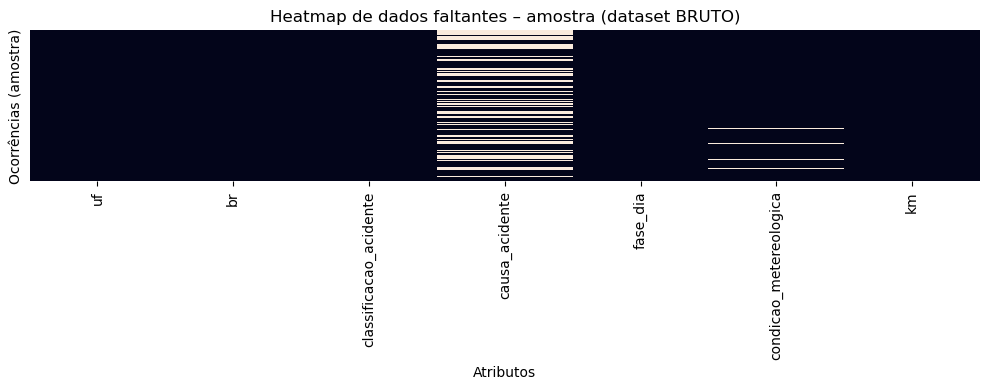

In [20]:
# Bloco 7 – heatmaps de dados faltantes (antes x depois da limpeza)

colunas_qualidade = [
    "uf",
    "br",
    "classificacao_acidente",
    "causa_acidente",
    "fase_dia",
    "condicao_metereologica",
    "km",
]

# para o dataset BRUTO, tratamos "(null)" como faltante só para visualização
df_raw_na = df_raw.replace("(null)", np.nan).replace("Ignorada", np.nan).replace("Outras", np.nan)

amostra_raw = df_raw_na[colunas_qualidade].sample(500, random_state=42)
amostra_limpa = df[colunas_qualidade].sample(500, random_state=42)

plt.figure(figsize=(10, 4))
sns.heatmap(amostra_raw.isna(), cbar=False, yticklabels=False)
plt.title("Heatmap de dados faltantes – amostra (dataset BRUTO)")
plt.xlabel("Atributos")
plt.ylabel("Ocorrências (amostra)")
plt.tight_layout()
plt.show()



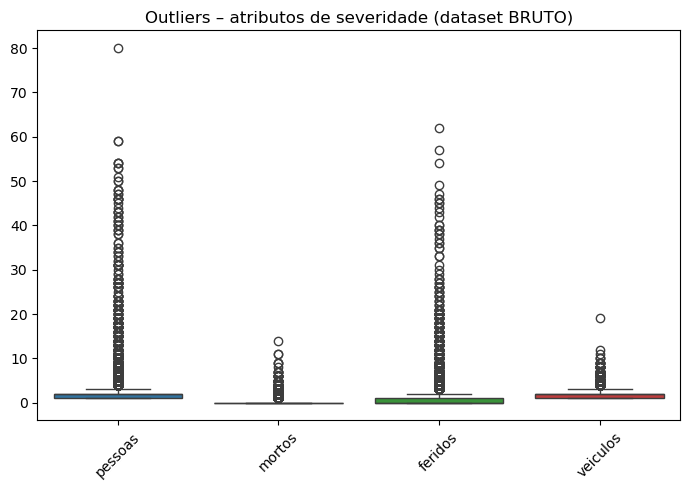

In [21]:
colunas_numericas_box = ["pessoas", "mortos", "feridos", "veiculos"]

plt.figure(figsize=(7, 5))
sns.boxplot(data=df_raw[colunas_numericas_box])
plt.title("Outliers – atributos de severidade (dataset BRUTO)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observam-se diversas linhas com valores "(null)" em algumas colunas (UF, BR, classificação do acidente, fase do dia, condição meteorológica e km), além de muitas ocorrências em que condicao_metereologica está marcada como "Ignorada" e causa_acidente como "Outras" o que indica informação pouco útil para análise.

O dataset bruto apresenta um número considerável de linhas em que km e br são "(null)" o que impedia que as colunas fossem convertidas para um tipo numérico.

Os outliers não apresentam valores absurdos, sendo seu possível impacto no desempenho do futuro modelo questionável. Por isso eles foram mantidos.

Dados tratados:

In [22]:
print("Contagem de valores problemáticos no dataset BRUTO")
con.execute("""
    SELECT
        SUM(CASE WHEN uf = '(null)' OR uf IS NULL THEN 1 ELSE 0 END)               AS n_uf_nulos,
        SUM(CASE WHEN br IS NULL THEN 1 ELSE 0 END)               AS n_br_nulos,
        SUM(CASE WHEN classificacao_acidente = '(null)' THEN 1 ELSE 0 END)         AS n_classificacao_nulos,
        SUM(CASE WHEN causa_acidente = 'Outras' THEN 1 ELSE 0 END)                 AS n_causa_outras,
        SUM(CASE WHEN fase_dia = '(null)' OR fase_dia IS NULL THEN 1 ELSE 0 END)   AS n_fase_dia_nulos,
        SUM(CASE WHEN condicao_metereologica = '(null)' OR condicao_metereologica IS NULL THEN 1 ELSE 0 END) AS n_cond_met_nulos,
        SUM(CASE WHEN condicao_metereologica = 'Ignorada' THEN 1 ELSE 0 END)       AS n_cond_met_ignorada,
        SUM(CASE WHEN km IS NULL THEN 1 ELSE 0 END)               AS n_km_nulos
    FROM acidentes;
""").df()



Contagem de valores problemáticos no dataset BRUTO


,n_uf_nulos,n_br_nulos,n_classificacao_nulos,n_causa_outras,n_fase_dia_nulos,n_cond_met_nulos,n_cond_met_ignorada,n_km_nulos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


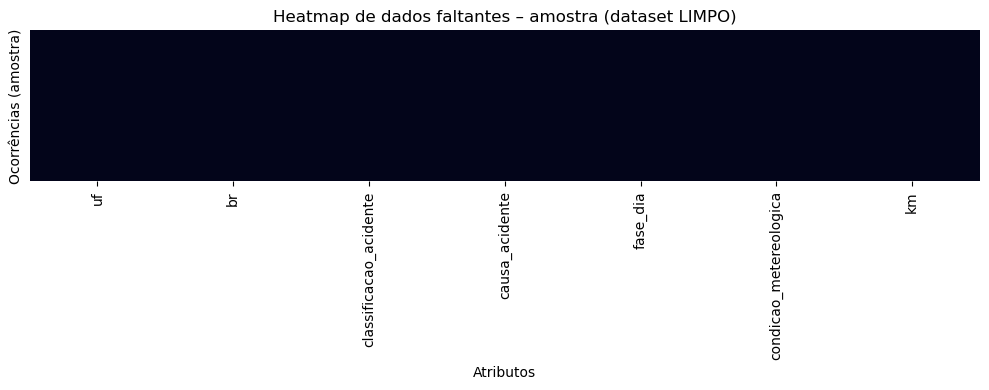

In [23]:
plt.figure(figsize=(10, 4))
sns.heatmap(amostra_limpa.isna(), cbar=False, yticklabels=False)
plt.title("Heatmap de dados faltantes – amostra (dataset LIMPO)")
plt.xlabel("Atributos")
plt.ylabel("Ocorrências (amostra)")
plt.tight_layout()
plt.show()

Após a limpeza (substituição de "(null)", "Ignorada" e "Outras"  por NaN e remoção das linhas incompletas), as mesmas consultas mostram que essas contagens de valores problemáticos diminuem para zero. Isso evidencia que os registros usados nas etapas seguintes já não carregam campos vazios ou categorias “lixo” nessas variáveis. Com a remoção dos valores nulos, a totalidade dos valores de km e br passou a ser convertível para tipo numérico.

###2.1 Enriquecimento com Fontes Externas (Opcional, mas encorajado)

In [24]:

df = df.merge(
    df_mun,
    on=['uf', 'municipio'],
    how='left'
)

faltantes = df[df['pop_2006'].isna()]
print(f"Linhas sem população: {len(faltantes)}")
faltantes[['uf', 'municipio']].head(20)

Linhas sem população: 172


,uf,municipio
241,BA,MUQUEM DO SAO FRANCISCO
376,SC,PICARRAS
565,RO,ITAPU� DO OESTE
1385,SC,PICARRAS
1759,RS,ENTRE IJUIS
2795,SC,PICARRAS
3716,RS,ENTRE IJUIS
3789,BA,MUQUEM DO SAO FRANCISCO
3944,SC,SAO MIGUEL DOESTE
4048,SC,SAO MIGUEL DOESTE


In [25]:
df["hora"] = df["horario"].map(lambda x: int(x.split(":")[0]))
df["mes"] = df["data_inversa"].map(lambda x: int(x.split("/")[1]))
df["fim_semana"] = df["dia_semana"].isin(["Sábado", "Domingo"])
df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,pop_2006,hora,mes,fim_semana
0,1051130,12/02/2007,Segunda,02:10:00,MA,135,11.0,SAO LUIS,Animais na Pista,Atropelamento de animal,...,2,1,0,0,3,1,998385.0,2,2,False
1,1066824,20/11/2007,Ter�a,05:30:00,CE,222,30.8,CAUCAIA,Defeito mec�nico em ve�culo,Capotamento,...,1,0,0,0,1,1,313584.0,5,11,False
2,1333766,17/07/2007,Ter�a,14:00:00,GO,70,372.0,MONTES CLAROS DE GOIAS,Falta de aten��o,Colis�o lateral,...,0,1,1,0,1,2,7652.0,14,7,False
3,173714,01/01/2007,Segunda,00:03:00,RJ,116,305.5,RESENDE,Animais na Pista,Atropelamento de animal,...,0,0,1,0,0,1,119729.0,0,1,False
4,173715,01/01/2007,Segunda,00:50:00,RJ,101,321.5,NITEROI,N�o guardar dist�ncia de seguran�a,Colis�o traseira,...,0,0,2,0,0,2,476669.0,0,1,False


In [27]:
df.to_csv("sinistros2007.csv")